### SCC5830 - Image Processing - Final Project
2019 - 1st semester

## Image restoration: Sinusoidal pattern removal


Concerning 

At first the main step is to import all libraries needed for this project. And then, defining a function to read an image.

In [1]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftshift, ifft2
import matplotlib.pyplot as plt
import imageio
from PIL import Image

In [2]:
def get_img():
    filename = str(input()).rstrip()
    img = imageio.imread(filename)
    return img

moonlanding_corrupted.png


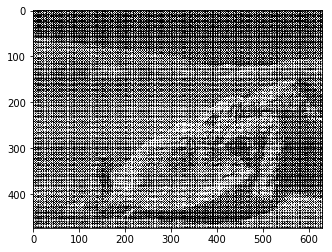

In [148]:
img = get_img()
plt.imshow(img, cmap = "gray")

As can be seen, this image has a high frequency noise, presented by the gingham pattern throughout the image.
Our goal here is to sucessfully remove this pattern without losing too much of information from the image itself.
Visualizing this image in the Fourier Spectra can help to better undestand what has to be done and how.

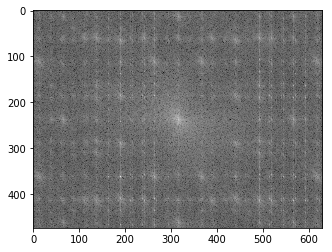

In [149]:
fimg = fftn(img)
fimg = (np.log(1+np.abs(fftshift(fimg))))
plt.imshow(np.real(fimg), cmap = "gray")


Analysing the Fourier Spectra, it can be said that some of the information available in the spectra can be seen on the image itself, such as a diagonal line corresponding to Lena's hat. However, four small dots can be found in each quadrant, these high frequency points are related to the patterns disturbing the image. 
With that said, removing these dots will most likely remove the noise on the image as well. Before that, let's define a function that converts images to frequency domain while doubles it in size.

In [150]:
def spatialtofreq(img):
    m, n = img.shape
    diff = abs(m-n)
    new_m, new_n = m, n
    if(m > n):
        new_n = n+diff
    else:
        new_m = m+diff  
    nimg = np.zeros((new_m,new_n))
    nimg[:m,:n] = img
    ftimg = fftn(nimg) 
    ftimg = fftshift(ftimg)
    #plt.imshow(np.real(nimg), cmap = "gray")
    return ftimg

The idea here is to create a function that filters out the minimun necessary area to remove the patterns on image. Because of that, a band-stop filter, that creates a band on a specific area and removes high frequencies on it is the advised approach to this project.
With that said, creating those filters to apply on the image is necessary. In this project the approach is to use Gaussian, Butterworth and Notch filters to filter out the smallest area possible in order not to lose to much information on the picture. 

In [5]:
def butterWorthFilter(euclideand, cutofffrequency, bandwidth, order):
            result = 1/(1+((euclideand*bandwidth)/((euclideand**2)-(cutofffrequency**2)))**(2.*order))
            return result

In [6]:
def gaussianFilter(euclideand, cutofffrequency, bandwidth):
            result = 1-np.exp(-((euclideand**2-cutofffrequency**2)/(euclideand*bandwidth))**2)
            return result

In [165]:
def in_circle(x,y,u,v,r):
    # calcula distancia do pixel [u,v] em relacao ao centro do circulo [x,y]
    dist_from_center = np.sqrt(np.square(u-x) + np.square(v-y))
    # retorna True se distancia for menor ou igual ao raio, e Falso c.c.
    return(dist_from_center <= r)

def notchFilter(filter, x, y, r):
    for u in range(x-r,x+r+1):
        for v in range(y-r,y+r+1):
            if(in_circle(u,v,x,y,r)):
                filter[u,v] = 0    
    return filter

        

After defining the mask, the next step is to create the band-stop filter itself. The outcome will depend on the type selected.

In [166]:
def createBandFilter(m, n, type, cutofffrequency, bandwidth, order):
    img = np.zeros((m,n))
    cx = np.floor(m/2)+1
    cy = np.floor(n/2)+1
    for x in range(m):
        for y in range(n):
            euclideand = np.sqrt((x-cx)**2+(y-cy)**2)
            if(type == "notchideal"):
                img[x,y] = notchFilter(img, i, j, r)
            elif(type == "butterworth"):
                img[x,y] = butterWorthFilter(euclideand, cutofffrequency, bandwidth, order)
            elif(type == "gaussian"):
                img[x,y] = gaussianFilter(euclideand, cutofffrequency, bandwidth)
    return img

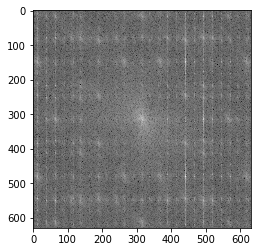

In [151]:
ftimg = spatialtofreq(img)
plt.imshow(np.log(1+np.abs(ftimg)), cmap = "gray")

Let's read some inputs to be applied on image. The bandwidth can be understood as the thickness of the band, while the Cut-off Frequency if the frequency to me removed.

In [163]:
m,n = ftimg.shape
bandwidth = 4000
cutofffrequency = 250
order = 2
r = 30


With that defined, let's visualize the band filter itself.

/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


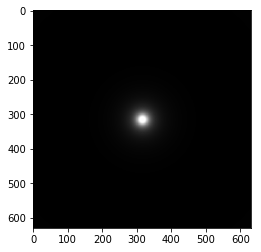

In [159]:
rejectBandFilter = createBandFilter(m, n, "gaussian", cutofffrequency, bandwidth, 2)
plt.imshow(rejectBandFilter, cmap = "gray")

Before applying the filter to the image, a function to convert the image from the frequency domain back to the spatial domain is necessary. This function also crops the image back to its original shape.

In [97]:
def freqtospatial(fimg, img):
    m, n = img.shape
    image = np.abs(ifft2(fimg))
    image = image.astype(np.uint8)
    crop_img = image[0:m, 0:n]
    return(crop_img)

After so, let's finally apply the filter to the image and convert it back to space domain to visualize it.

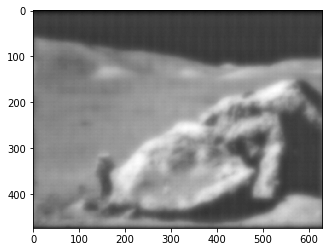

In [160]:
filteredImageRejectBandIdeal =freqtospatial(np.multiply(ftimg,rejectBandFilter),img)
plt.imshow(filteredImageRejectBandIdeal, cmap = "gray")

As can be seen above, the image now has no pattern at all, however, since the band-stop filter removed, according to its name, a band around the frequency domain, some of the information is lost. A notch filter would carve out the specific regions where the high frequency patterns are, without compromising the image quality, sharpness, or definition.